#### Chapter 22
### Analyzing Neural Time Series Data
Python code for Chapter 22 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fftpack import fft, ifft
from mne import create_info, EvokedArray
from mne.channels import make_dig_montage
from laplacian_perrinX import laplacian_perrinX
from laplacian_nola import laplacian_nola
import time

In [ ]:
# Figure 22.2

# This figure was made by 'stepping-in' to the function laplacian_perrinX
# and then creating topographical maps of the Legendre polynomial.
# TODO: Python equivalent of 'stepping-in' to a function.

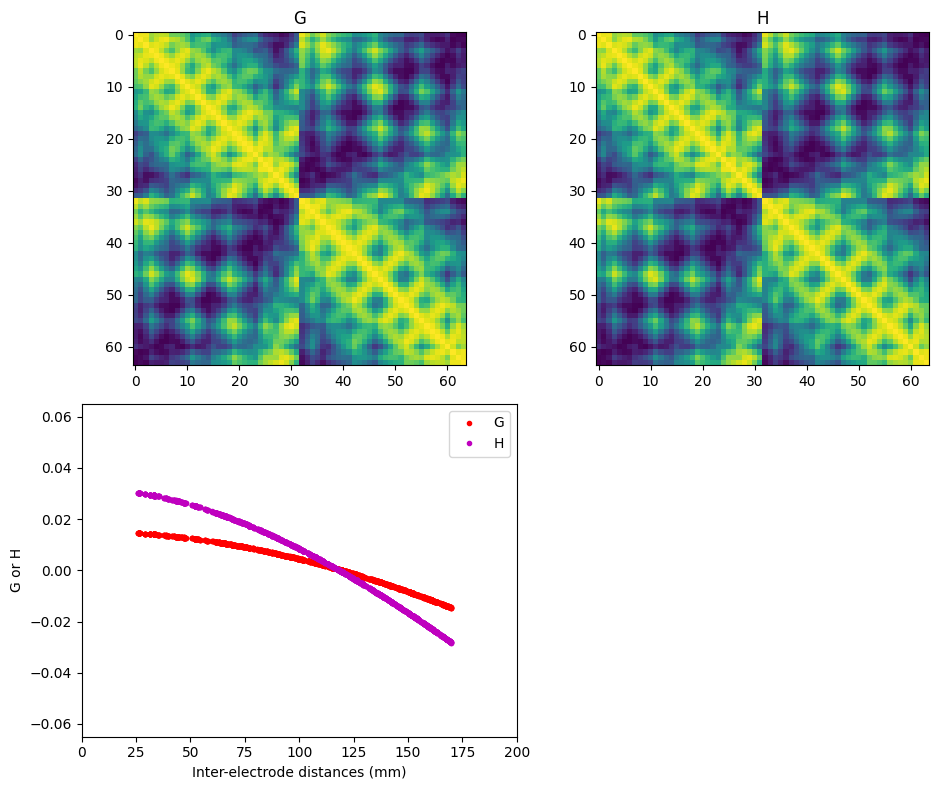

In [ ]:
# Figure 22.3

# Load sample EEG dataset
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Compute inter-electrode distances
interelectrodedist = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for chani in range(EEG['nbchan'][0][0]):
    for chanj in range(chani + 1, EEG['nbchan'][0][0]):
        interelectrodedist[chani, chanj] = np.sqrt(
            (EEG['chanlocs'][0][chani]['X'][0][0] - EEG['chanlocs'][0][chanj]['X'][0][0]) ** 2 +
            (EEG['chanlocs'][0][chani]['Y'][0][0] - EEG['chanlocs'][0][chanj]['Y'][0][0]) ** 2 +
            (EEG['chanlocs'][0][chani]['Z'][0][0] - EEG['chanlocs'][0][chanj]['Z'][0][0]) ** 2
        )

valid_gridpoints = np.where(interelectrodedist > 0)

# Extract XYZ coordinates from EEG structure
X = np.array([chan['X'][0][0] for chan in EEG['chanlocs'][0]])
Y = np.array([chan['Y'][0][0] for chan in EEG['chanlocs'][0]])
Z = np.array([chan['Z'][0][0] for chan in EEG['chanlocs'][0]])

# Crreate the G and H matrices
surf_lap, G, H = laplacian_perrinX(np.random.rand(len(X)), X, Y, Z, smoothing=1e-6)
# Note we define the laplacian_perrinX function in the file laplacian_perrinX.py

# Plot G and H matrices
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(G, cmap='viridis')
plt.title('G')

plt.subplot(222)
plt.imshow(H, cmap='viridis')
plt.title('H')

plt.subplot(223)
plt.plot(interelectrodedist[valid_gridpoints], G[valid_gridpoints], 'r.')
plt.plot(interelectrodedist[valid_gridpoints], H[valid_gridpoints], 'm.')
plt.legend(['G', 'H'])
plt.xlim([0, 200])
plt.ylim([-0.065, 0.065])
plt.xlabel('Inter-electrode distances (mm)')
plt.ylabel('G or H')

plt.tight_layout()
plt.show()

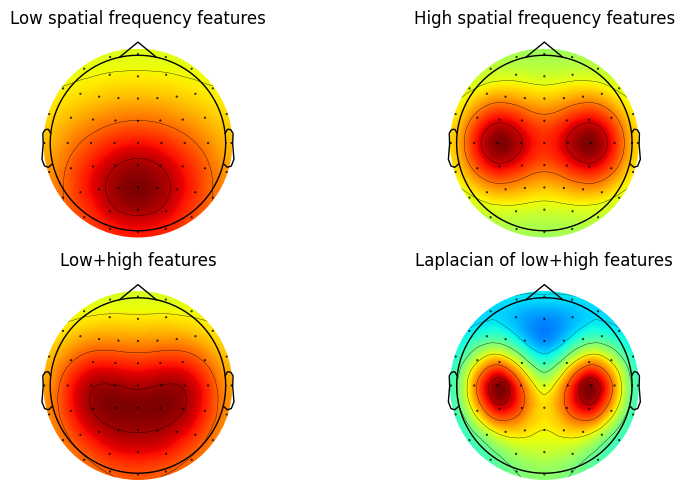

In [ ]:
# Figure 22.4

# In the book, figure 4 uses chan1 as Pz. The book also mentions that tha
# surface Laplacian will attenuate the impact of EOG artifacts. This can be
# simulated here by setting chan1 to FPz. 

chan1 = 'Pz'
chan2 = 'C4'
chan3 = 'C3'

eucdist1 = np.zeros(EEG['nbchan'][0][0])
eucdist2 = np.zeros(EEG['nbchan'][0][0])
eucdist3 = np.zeros(EEG['nbchan'][0][0])

chan1idx = EEG['chanlocs'][0]['labels']==chan1
chan2idx = EEG['chanlocs'][0]['labels']==chan2
chan3idx = EEG['chanlocs'][0]['labels']==chan3

# Calculate the Euclidean distances
for chani in range(EEG['nbchan'][0][0]):
    eucdist1[chani] = np.sqrt((EEG['chanlocs'][0][chani]['X'][0][0] - EEG['chanlocs'][0][chan1idx]['X'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Y'][0][0] - EEG['chanlocs'][0][chan1idx]['Y'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Z'][0][0] - EEG['chanlocs'][0][chan1idx]['Z'][0][0])**2)
    eucdist2[chani] = np.sqrt((EEG['chanlocs'][0][chani]['X'][0][0] - EEG['chanlocs'][0][chan2idx]['X'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Y'][0][0] - EEG['chanlocs'][0][chan2idx]['Y'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Z'][0][0] - EEG['chanlocs'][0][chan2idx]['Z'][0][0])**2)
    eucdist3[chani] = np.sqrt((EEG['chanlocs'][0][chani]['X'][0][0] - EEG['chanlocs'][0][chan3idx]['X'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Y'][0][0] - EEG['chanlocs'][0][chan3idx]['Y'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Z'][0][0] - EEG['chanlocs'][0][chan3idx]['Z'][0][0])**2)

# Compute spatial frequencies
hi_spatfreq = 2 * np.exp(-eucdist1 ** 2 / (2 * 95 ** 2))
lo_spatfreq = np.exp(-eucdist2 ** 2 / (2 * 50 ** 2)) + np.exp(-eucdist3 ** 2 / (2 * 50 ** 2))
surf_lap_all, _, _ = laplacian_perrinX(hi_spatfreq + lo_spatfreq, X, Y, Z)

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
hi_spatfreq = np.delete(hi_spatfreq, exclude_chans)
lo_spatfreq = np.delete(lo_spatfreq, exclude_chans)
surf_lap_all = np.delete(surf_lap_all, exclude_chans)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot the surface Laplacian
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
evoked = EvokedArray(hi_spatfreq[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[0, 0], show=False, times=-1, time_format='', colorbar=False)
axs[0, 0].set_title('Low spatial frequency features')

evoked = EvokedArray(lo_spatfreq[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[0, 1], show=False, times=-1, time_format='', colorbar=False)
axs[0, 1].set_title('High spatial frequency features')

evoked = EvokedArray(hi_spatfreq[:, np.newaxis] + lo_spatfreq[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[1, 0], show=False, times=-1, time_format='', colorbar=False)
axs[1, 0].set_title('Low+high features')

evoked = EvokedArray(surf_lap_all[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[1, 1], show=False, times=-1, time_format='', colorbar=False)
axs[1, 1].set_title('Laplacian of low+high features')

plt.tight_layout()
plt.show()

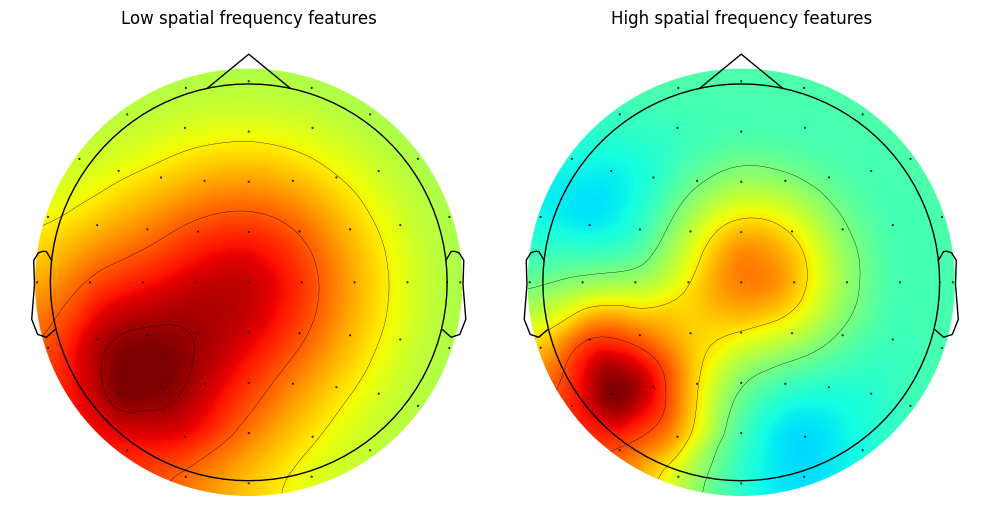

In [ ]:
# Another example similar to Figure 4

# Define channels for analysis
chan1 = 'Cz'
chan2 = 'P5'

eucdist1 = np.zeros(EEG['nbchan'][0][0])
eucdist2 = np.zeros(EEG['nbchan'][0][0])

chan1idx = EEG['chanlocs'][0]['labels']==chan1
chan2idx = EEG['chanlocs'][0]['labels']==chan2

# Calculate the Euclidean distances
for chani in range(EEG['nbchan'][0][0]):
    eucdist1[chani] = np.sqrt((EEG['chanlocs'][0][chani]['X'][0][0] - EEG['chanlocs'][0][chan1idx]['X'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Y'][0][0] - EEG['chanlocs'][0][chan1idx]['Y'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Z'][0][0] - EEG['chanlocs'][0][chan1idx]['Z'][0][0])**2)
    eucdist2[chani] = np.sqrt((EEG['chanlocs'][0][chani]['X'][0][0] - EEG['chanlocs'][0][chan2idx]['X'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Y'][0][0] - EEG['chanlocs'][0][chan2idx]['Y'][0][0])**2 +
                               (EEG['chanlocs'][0][chani]['Z'][0][0] - EEG['chanlocs'][0][chan2idx]['Z'][0][0])**2)

# Compute data to use
data2use = np.exp(-eucdist1 ** 2 / (2 * 65 ** 2)) + np.exp(-eucdist2 ** 2 / (2 * 50 ** 2))

# Compute surface Laplacian
surf_lap, _, _ = laplacian_perrinX(data2use, X, Y, Z)

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
data2use = np.delete(data2use, exclude_chans)
surf_lap = np.delete(surf_lap, exclude_chans)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot topographic maps using plot_topomap
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
evoked = EvokedArray(data2use[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[0], show=False, times=-1, time_format='', colorbar=False)
axs[0].set_title('Low spatial frequency features')

evoked = EvokedArray(surf_lap[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[1], show=False, times=-1, time_format='', colorbar=False)
axs[1].set_title('High spatial frequency features')

plt.tight_layout()
plt.show()

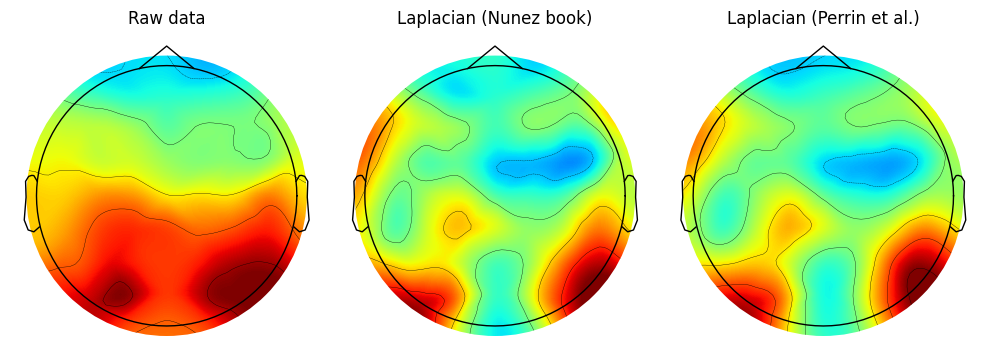

Spatial correlation: r=0.9814967637990577


In [ ]:
# Figure 22.5

# Use the mean of the EEG data at a specific time point
data2use = np.mean(EEG['data'][:, 320, :], axis=1)

# Compute surface Laplacian using Nunez and Perrin methods
surf_lapN = laplacian_nola(X, Y, Z, data2use, smoothing=100)
surf_lapP, _, _ = laplacian_perrinX(data2use, X, Y, Z, smoothing=1e-5)
# note: try changing the smoothing parameter above (last input argument) to
# see the effects of the smoothing (lambda) parameter. Reasonable values
# are 1e-4 to 1e-6, and the default parameter is 1e-5.

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
data2use = np.delete(data2use, exclude_chans)
surf_lapN = np.delete(surf_lapN, exclude_chans)
surf_lapP = np.delete(surf_lapP, exclude_chans)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot topographic maps using plot_topomap
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
evoked = EvokedArray(data2use[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sensors=False, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[0], show=False, times=-1, time_format='', colorbar=False)
axs[0].set_title('Raw data')

evoked = EvokedArray(surf_lapN[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sensors=False, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[1], show=False, times=-1, time_format='', colorbar=False)
axs[1].set_title('Laplacian (Nunez book)')

evoked = EvokedArray(surf_lapP[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sensors=False, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', axes=axs[2], show=False, times=-1, time_format='', colorbar=False)
axs[2].set_title('Laplacian (Perrin et al.)')

plt.tight_layout()
plt.show()

# Display spatial correlation between the two Laplacian methods
spatial_corr = np.corrcoef(surf_lapN, surf_lapP)[0, 1]
print(f"Spatial correlation: r={spatial_corr}")

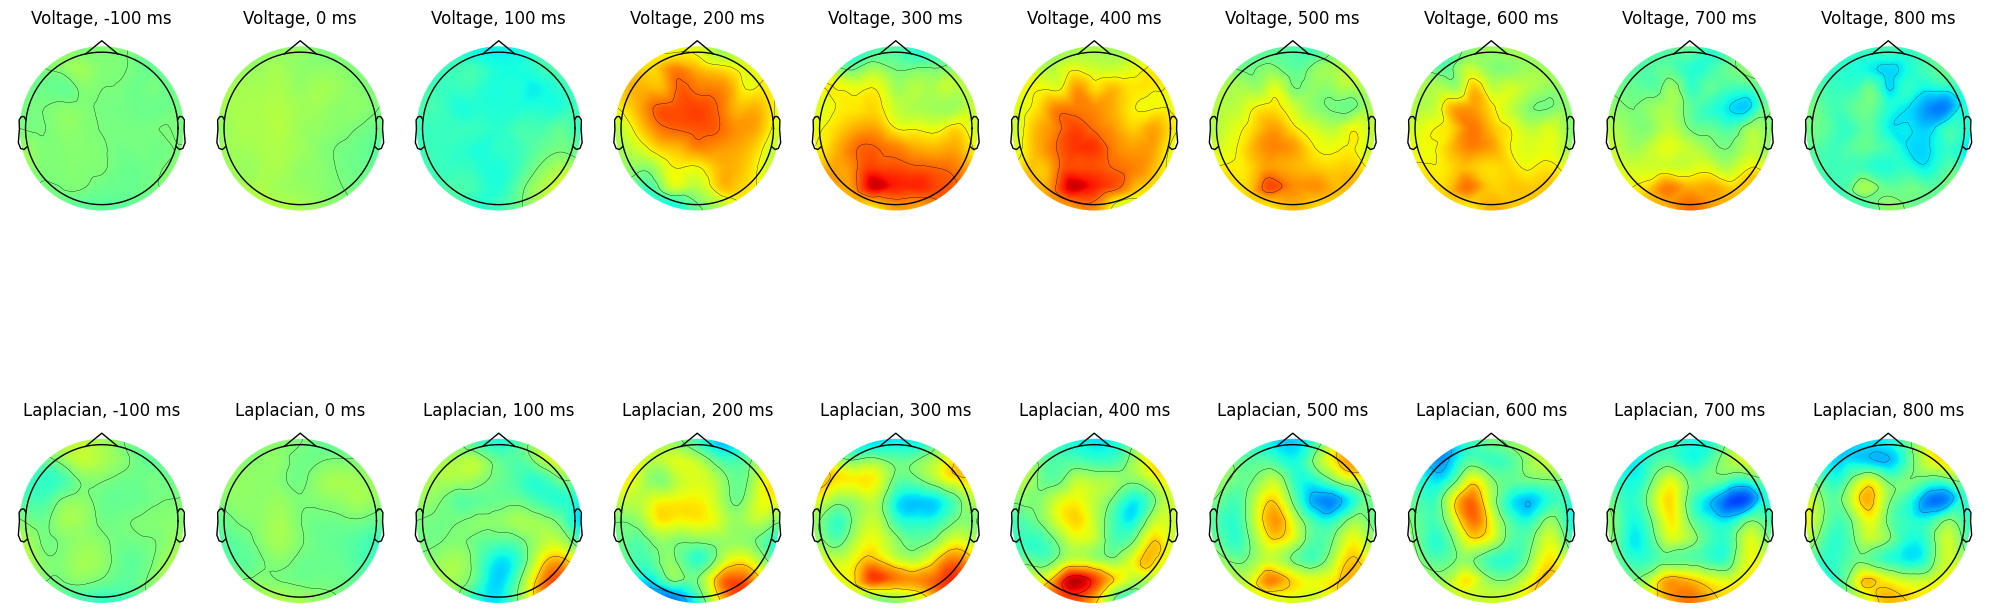

In [ ]:
# Figure 22.6

# Timing is included in case you want to test the Perrin and New Orleans methods
timetest = []

# Start timing for the first laplacian function
start_time = time.time()
lap_data, _, _ = laplacian_perrinX(EEG['data'], X, Y, Z)
# Calculate elapsed time and store it
elapsed_time = time.time() - start_time
timetest.append(elapsed_time)

# Start timing for the second laplacian function
start_time = time.time()
lap_data2 = laplacian_nola(X, Y, Z, EEG['data'])
# Calculate elapsed time and store it
elapsed_time = time.time() - start_time
timetest.append(elapsed_time)

# Define times to plot
times2plot = np.arange(-100, 900, 100)

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
eeg_data = np.delete(EEG['data'], exclude_chans, axis=0)
Xlp = np.delete(X, exclude_chans)
Ylp = np.delete(Y, exclude_chans)
Zlp = np.delete(Z, exclude_chans)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot voltage and Laplacian maps at different time points
fig, ax = plt.subplots(2, len(times2plot), figsize=(20, 10))
for i, time_point in enumerate(times2plot):
    # Find time index
    timeidx = np.argmin(np.abs(EEG['times'] - time_point))
    
    # Get the mean data at the specified time point
    tempdata = np.mean(eeg_data[:, timeidx, :], axis=1)
    
    # Plot voltage map (spatially unfiltered)
    evoked = EvokedArray(tempdata[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
    evoked.set_montage(montage)
    evoked.plot_topomap(sensors=False, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', vlim=(-10000000, 10000000), axes=ax[0, i], show=False, times=-1, time_format='', colorbar=False)
    ax[0, i].set_title(f'Voltage, {time_point} ms')
    
    # Plot Laplacian map (spatially filtered)
    evoked = EvokedArray(laplacian_perrinX(tempdata, Xlp, Ylp, Zlp)[0][:, np.newaxis], info, tmin=EEG['xmin'][0][0])
    evoked.set_montage(montage)
    evoked.plot_topomap(sensors=False, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', vlim=(-40000000, 40000000), axes=ax[1, i], show=False, times=-1, time_format='', colorbar=False)
    ax[1, i].set_title(f'Laplacian, {time_point} ms')

plt.tight_layout()
plt.show()

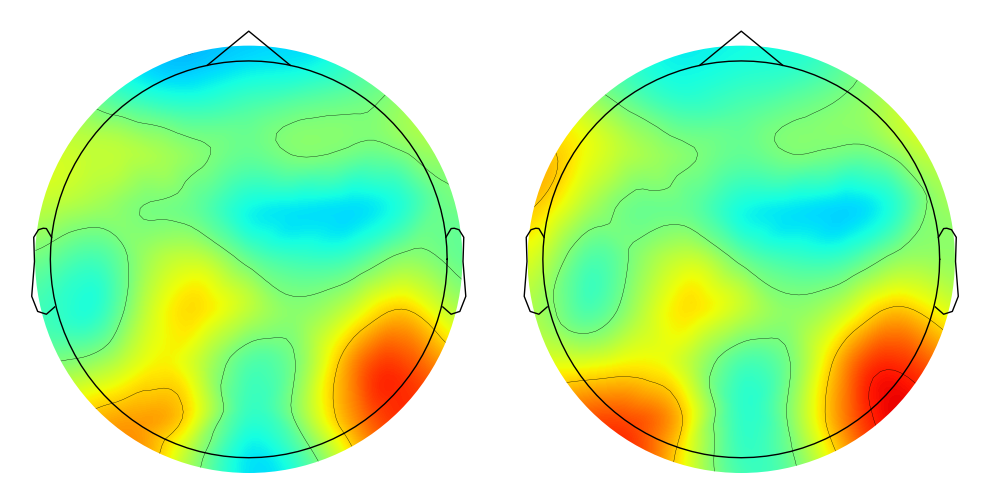

In [ ]:
# Brief aside:

# This figure shows that computing the Laplacian of the ERP is the same as
# computing the Laplacian of single trials and then taking the ERP. This is
# not surprising: the ERP is a linear transform of the single trials.

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
eeg_data = np.delete(EEG['data'], exclude_chans, axis=0)
X_lp = np.delete(X, exclude_chans)
Y_lp = np.delete(Y, exclude_chans)
Z_lp = np.delete(Z, exclude_chans)
lap_data_lp = np.delete(lap_data, exclude_chans, axis=0)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot the comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
evoked = EvokedArray(laplacian_perrinX(np.mean(eeg_data[:, 320, :], axis=1), X_lp, Y_lp, Z_lp)[0][:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sensors=False, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', vlim=(-40000000, 40000000), axes=axs[0], show=False, times=-1, time_format='', colorbar=False)

evoked = EvokedArray(np.mean(lap_data_lp[:, 320, :], axis=1)[:, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sensors=False, sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', vlim=(-40000000, 40000000), axes=axs[1], show=False, times=-1, time_format='', colorbar=False)

plt.tight_layout()
plt.show()

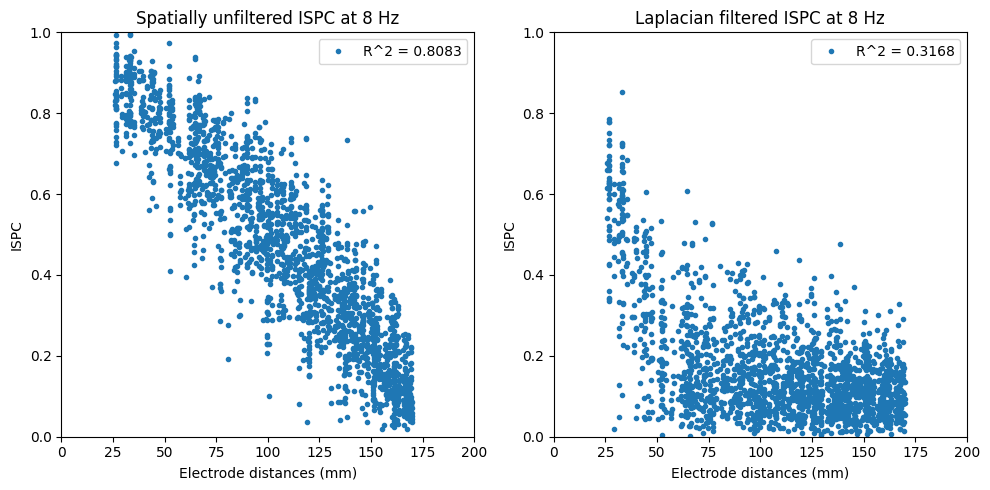

In [ ]:
# Figure 22.7

# Define frequency and time of interest
freq2use = 8  # Hz
time2use = 400  # ms

# FFT parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1
n_conv2 = int(2**np.ceil(np.log2(n_convolution)))

# Create wavelet and get FFT
wavelet_fft = fft(np.exp(2 * 1j * np.pi * freq2use * time) * np.exp(-time ** 2 / (2 * (4 / (2 * np.pi * freq2use)) ** 2)) / freq2use, n_conv2)
half_of_wavelet_size = (len(time) - 1) // 2

# Initialize
allphases_pre = np.zeros(EEG['data'].shape, dtype=complex)
allphases_lap = np.zeros(EEG['data'].shape, dtype=complex)
ispc_pre = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
ispc_lap = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
timeidx = np.argmin(np.abs(EEG['times'] - time2use))

# Get all phases
for chani in range(EEG['nbchan'][0][0]):
    # First for nonspatially filtered data
    fft_data = fft(EEG['data'][chani, :, :].flatten('F'), n_conv2)
    conv_res = ifft(wavelet_fft * fft_data, n_conv2)
    conv_res = conv_res[:n_convolution]
    conv_res = conv_res[half_of_wavelet_size:-half_of_wavelet_size]
    allphases_pre[chani, :, :] = np.reshape(conv_res, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Then for Laplacian filtered data
    fft_data = fft(lap_data[chani, :, :].flatten('F'), n_conv2)
    conv_res = ifft(wavelet_fft * fft_data, n_conv2)
    conv_res = conv_res[:n_convolution]
    conv_res = conv_res[half_of_wavelet_size:-half_of_wavelet_size]
    allphases_lap[chani, :, :] = np.reshape(conv_res, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

# Compute synchrony
for chani in range(EEG['nbchan'][0][0]):
    for chanj in range(chani + 1, EEG['nbchan'][0][0]):
        # Cross-spectral density for nonspatially filtered data
        cd_pre = allphases_pre[chani, timeidx, :] * np.conj(allphases_pre[chanj, timeidx, :])
        ispc_pre[chani, chanj] = np.abs(np.mean(np.exp(1j * np.angle(cd_pre))))
        
        # Cross-spectral density for Laplacian filtered data
        cd_lap = allphases_lap[chani, timeidx, :] * np.conj(allphases_lap[chanj, timeidx, :])
        ispc_lap[chani, chanj] = np.abs(np.mean(np.exp(1j * np.angle(cd_lap))))

# Mirror connectivity matrices
ispc_pre = ispc_pre + ispc_pre.T + np.eye(EEG['nbchan'][0][0])
ispc_lap = ispc_lap + ispc_lap.T + np.eye(EEG['nbchan'][0][0])

# Plot ISPC as a function of electrode distances
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(interelectrodedist[valid_gridpoints], ispc_pre[valid_gridpoints], '.')
plt.xlim([0, 200])
plt.ylim([0, 1])
plt.xlabel('Electrode distances (mm)')
plt.ylabel('ISPC')
plt.title(f'Spatially unfiltered ISPC at {freq2use} Hz')
r_pre = np.corrcoef(interelectrodedist[valid_gridpoints], ispc_pre[valid_gridpoints])[0, 1]
plt.legend([f'R^2 = {r_pre ** 2:.4f}'])

plt.subplot(122)
plt.plot(interelectrodedist[valid_gridpoints], ispc_lap[valid_gridpoints], '.')
plt.xlim([0, 200])
plt.ylim([0, 1])
plt.xlabel('Electrode distances (mm)')
plt.ylabel('ISPC')
plt.title(f'Laplacian filtered ISPC at {freq2use} Hz')
r_lap = np.corrcoef(interelectrodedist[valid_gridpoints], ispc_lap[valid_gridpoints])[0, 1]
plt.legend([f'R^2 = {r_lap ** 2:.4f}'])

plt.tight_layout()
plt.show()

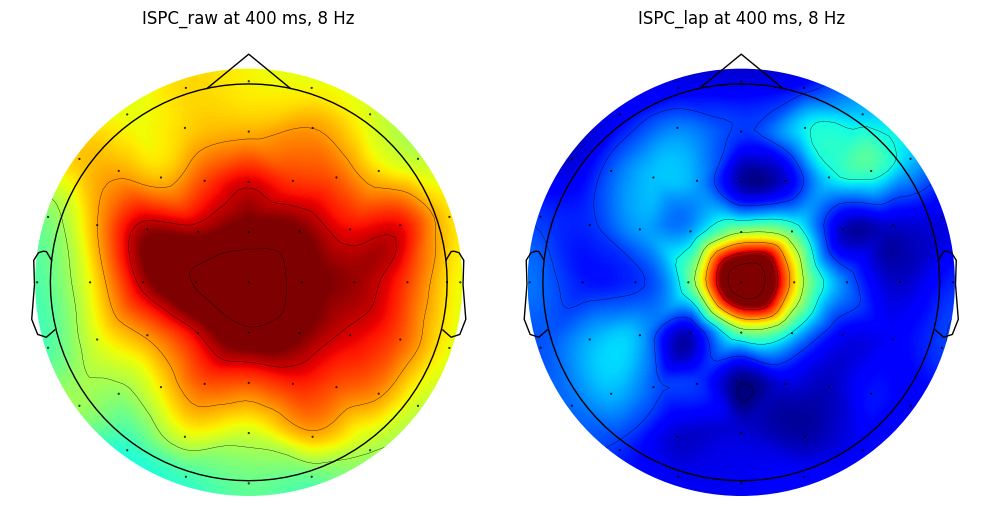

In [ ]:
# Figure 22.8

# create channel montage 
chan_labels = [chan['labels'][0] for chan in EEG['chanlocs'][0]]
coords = np.vstack([-1*EEG['chanlocs']['Y'], EEG['chanlocs']['X'], EEG['chanlocs']['Z']]).T
# remove channels outside of head
exclude_chans = np.where(np.array([chan['radius'][0][0] for chan in EEG['chanlocs'][0]]) > 0.54)
coords = np.delete(coords, exclude_chans, axis=0)
chan_labels = np.delete(chan_labels, exclude_chans)
ispc_pre_lp = np.delete(ispc_pre, exclude_chans, axis=1)
ispc_lap_lp = np.delete(ispc_lap, exclude_chans, axis=1)
montage = make_dig_montage(ch_pos=dict(zip(chan_labels, coords)), coord_frame='head')

# create MNE Info and Evoked object
info = create_info(list(chan_labels), EEG['srate'], ch_types='eeg')

# Plot topographic maps of ISPC for a specific channel (e.g., channel 48)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
evoked = EvokedArray(ispc_pre_lp[47, :, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', vlim=(0, 800000), axes=axs[0], show=False, times=-1, time_format='', colorbar=False)
axs[0].set_title(f'ISPC_raw at {time2use} ms, {freq2use} Hz')

evoked = EvokedArray(ispc_lap_lp[47, :, np.newaxis], info, tmin=EEG['xmin'][0][0])
evoked.set_montage(montage)
evoked.plot_topomap(sphere=EEG['chanlocs'][0][0]['sph_radius'][0][0], cmap='jet', vlim=(0, 800000), axes=axs[1], show=False, times=-1, time_format='', colorbar=False)
axs[1].set_title(f'ISPC_lap at {time2use} ms, {freq2use} Hz')

plt.tight_layout()
plt.show()